In [1]:
from PIL import Image
import scipy.stats
import scipy.io
import glob
import numpy as np
from numpy import linalg as la

import matplotlib.pyplot as plt 
from ipython_utilities import *
from IPython.display import display, HTML
import cv2
from pathlib import Path

%config Completer.use_jedi = False

In [4]:

image=[]
flattened_images  =[]
def griddisplay(image_list):
    fig1, axes_array = plt.subplots(10, 10)
    fig1.set_size_inches(12,12)
    k=0
    for row in range(10):
        for col in range(10):    
            im =cv2.resize(image_list[k],(100,100))
            image_plot = axes_array[row][col].imshow(im,cmap=plt.cm.gray) 
            axes_array[row][col].axis('off')
            k = k+1
    plt.show()
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
for filename in glob.glob("faces/*.png"):
  
    im = Image.open(filename).convert('L')
    im = np.asarray(im,dtype = float)/255.0
    im = cv2.resize(im,(200,200), interpolation = cv2.INTER_AREA)
    image.append(im)
    
    
for i in range(len(image)):
    flat = image[i].flatten()
    flattened_images.append(flat)


A_transpose = np.matrix(flattened_images) 
A = np.transpose(A_transpose)

# find mean of A
mean = np.mean(A,1)
# reshape the mean to see the result
mean_image = mean.reshape(image[0].shape)

m,n = image[0].shape

l,j = A.shape

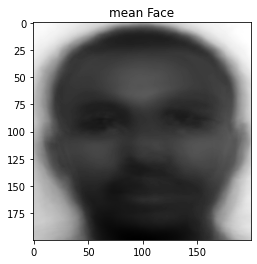

In [5]:
plt.imshow(mean_image,cmap='gray')

plt.title('mean Face')
plt.show()

Zero mean faces


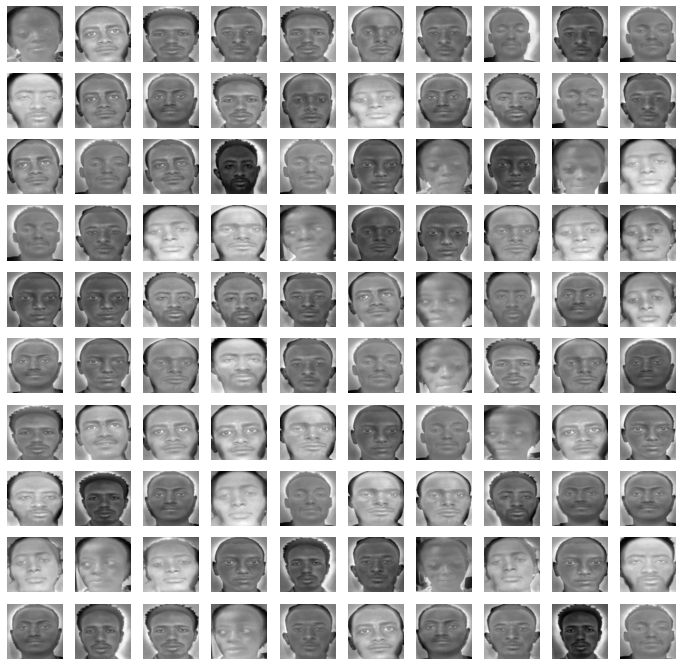

eigenfaces


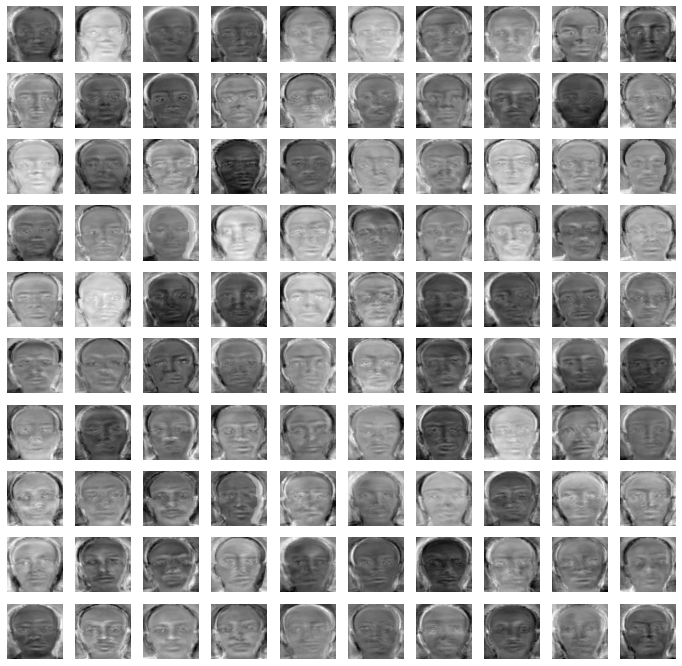

In [8]:
# compute the mean-substruccted image
zero_mean =[]
column =0
Zero_mean_matrix = np.ones((A.shape))

for values in flattened_images:
    zm = A[:,column]- mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] = zm
    zm_images = zm.resize(m,n)
    zero_mean.append(zm)
    column +=1
print('Zero mean faces')
griddisplay(zero_mean)


X = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/192

u_list =[]
w2,v2 = la.eigh(X)

for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix,ev_transpose)
    
    u = u/np.linalg.norm(u)
    
    u_i = u.reshape(m,n)
    u_list.append(u_i)

    
print('eigenfaces')
griddisplay(u_list)

		k =2


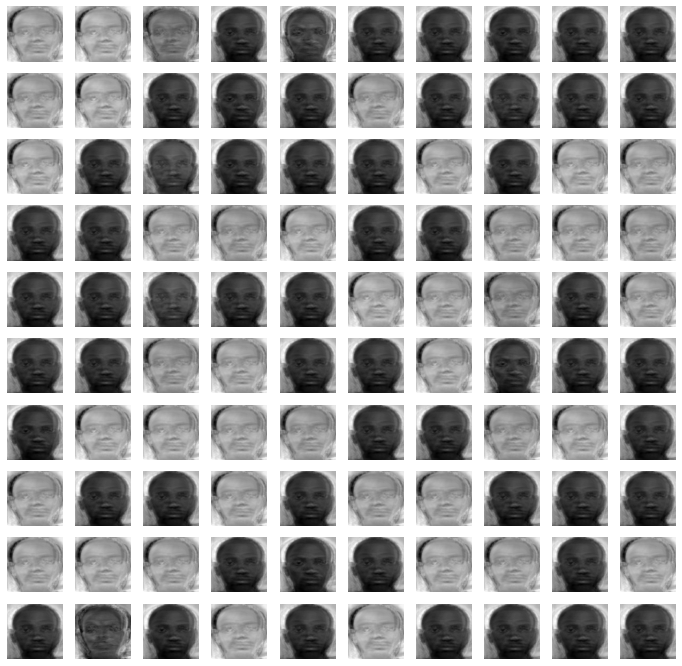

		k =10


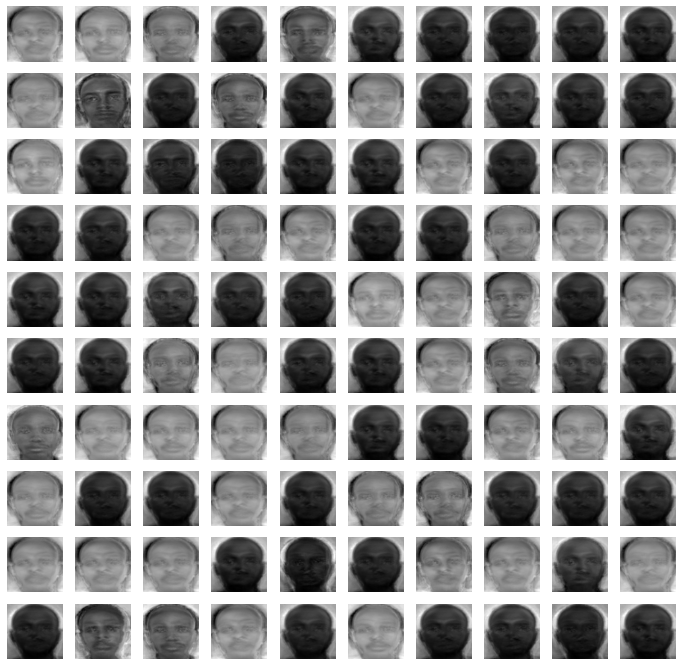

		k =50


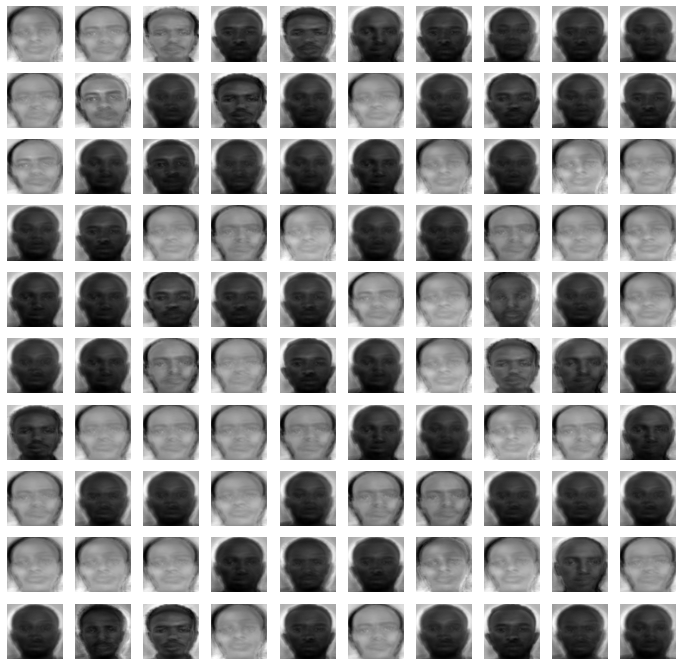

In [9]:
#Reconstruct
# l,j = A.shape 

dict1 ={}

def Reconstruct(k,boolean):
    weights = np.zeros((j,k))
    matrixU = np.zeros((l,k))
    c=0
    
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c +=1
    rec_face=[]
    
    for face_num in range(0,j):
        
        w = np.dot(np.transpose(matrixU), Zero_mean_matrix[:,face_num])
        
        weights[face_num,:] =w
        
        face = np.dot(w,np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        
        face = face/float((maxf-minf))
        face = face+np.transpose(mean)
        
        reshape_face =face.reshape(m,n)
        rec_face.append(reshape_face)
    if boolean is True:
        griddisplay(rec_face)
    dict1[k] = weights

print('\t\tk =2')
Reconstruct(2,True)

print('\t\tk =10')
Reconstruct(10,True)

print('\t\tk =50')
Reconstruct(50,True)
        

		 k=2


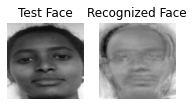

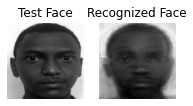

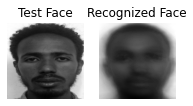

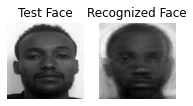

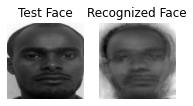

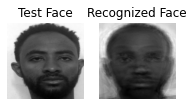

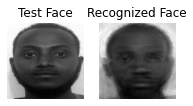

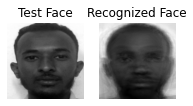

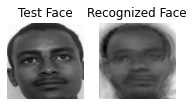

		 k=10


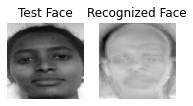

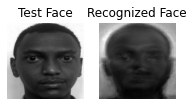

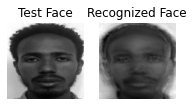

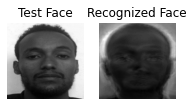

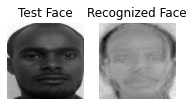

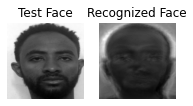

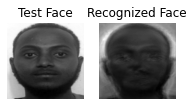

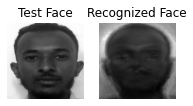

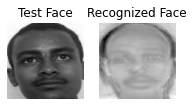

		 k=50


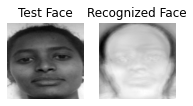

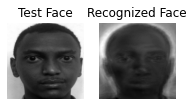

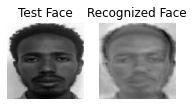

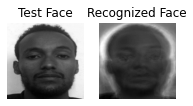

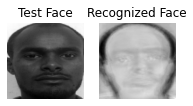

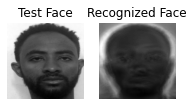

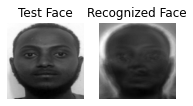

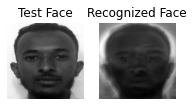

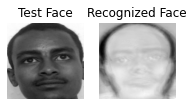

In [10]:
# predict 

test_images =[]

for filename in glob.glob("test/*.png"):
    im = Image.open(filename).convert('L')
    im = np.asarray(im,dtype = float)/255.0
    im = cv2.resize(im,(200,200), interpolation = cv2.INTER_AREA)
    test_images.append(im)
    


def predict (k,zero_mean_test,threshold):
    
    matrixU = np.zeros((l,k))
    c = 0
    
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
        
    w = np.dot(np.transpose(matrixU), np.transpose(zero_mean_test))
    original_w_k = dict1[k]
    dist =[]
    
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))
        
    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    
    fig1, axes_array = plt.subplots(1,2)
    fig1.set_size_inches(3,3)
    
    zero_mean_test =zero_mean_test + np.transpose(mean)
    zero_mean_test = zero_mean_test.reshape(m,n)
    image_plot = axes_array[0].imshow(zero_mean_test, cmap=plt.cm.gray)
    
    axes_array[0].axis('off')
    axes_array[0].set(title='Test Face')
    
    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face + np.transpose(mean)
    reshape_face = face.reshape(m,n)
    
    if np.min(dist) < threshold: #Nonface
        image_plot = axes_array[1].imshow(reshape_face, cmap =plt.cm.gray)
    
    axes_array[1].axis('off')
    axes_array[1].set(title='Recognized Face')
    plt.show()
    

def runs(k):
    for num in range(0,len(test_images)):
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test- np.transpose(mean)
        predict(k,zero_mean_test, 80) 
        
        
print('\t\t k=2')
runs(2)

print('\t\t k=10')
runs(10)

print('\t\t k=50')
runs(50)